In [15]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, Dataset
from torch.optim import lr_scheduler
from model import CNN, BasicBlock, ResNet, PretrainedAlexnet, PretrainedAlexnet_binary, PretrainedResnet, PretrainedResnet_binary
from tqdm import tqdm


In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device=='cuda':
    torch.cuda.manual_seed_all(777)
    
learning_rate = 1e-4
num_epochs = 15
batch_size = 32
input_size = 224 # CNN 모델은 input_size가 227이고 나머지 모델은 224이다.

datapath = 'dataset' # train, test data가 있는 폴더 경로이다.

In [17]:
is_binary = True # is_binary가 True이면 [일반쓰레기, 일반 쓰레기가 아닌 것] 두 개의 class로 분류하는 binary classifier를 학습한다.
if is_binary:
    datapath = 'dataset_binary'

In [18]:
# 데이터 augmentation을 위하여 CustomDataset class를 정의하였다.
class CustomDataset(Dataset):
    def __init__(self, imgs, transform=None):
        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img = self.imgs[idx][0]
        if self.transform:
            img = self.transform(img)

        return img, self.imgs[idx][1]


In [19]:
# 전체 이미지 데이터를 가져온다. 이미지를 가져올 때 위에서 정의한 input_size롤 resize 해서 가져온다.
# is_binary에 따라 datapath가 달라진다. 
# is_binary가 True이면 dataset_binary 폴더에서 [recycle, trash] 두 가지 클래스를 가지는 이미지 데이터를 가져온다.
# is_binary가 False이면 dataset 폴더에서 [cardboard, glass, metal, paper, plastic, trash] 6가지 클래스를 가지는 이미지 데이터를 가져온다.
trans = transforms.Resize((input_size, input_size))
train_set = torchvision.datasets.ImageFolder(datapath+'/train', transform=trans)
classes = train_set.classes

In [20]:
# 가져온 이미지 데이터를 train 데이터와 validation 데이터로 나눈다.
train_size = int(0.8 * len(train_set))
valid_size = len(train_set) - train_size
train_set, valid_set = torch.utils.data.random_split(train_set, [train_size, valid_size])

In [21]:
# train 데이터에 augmentation을 적용한다.
train_set = CustomDataset(train_set, transforms.Compose([
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
]))

# validation 데이터는 tensor로만 변경해준다..
valid_set = CustomDataset(valid_set, transforms.Compose([
    transforms.ToTensor(),
]))


In [22]:
train_len = len(train_set)
class_weights = [0] * len(classes)
sample_weights = [0] * train_len

for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    class_weights[label]+=1
for i in tqdm(range(len(classes))):
    class_weights[i] = (train_len-class_weights[i])/train_len
for idx, (data, label) in tqdm(enumerate(train_set), total=train_len):
    sample_weights[idx] = class_weights[label]

# 이미지 데이터의 class별 데이터 수가 불균형하기 때문에 WeightedRandomSampler를 적용한다.
# 각 class별 weight은 ((전체 데이터 수) - (해당 class 데이터 수)) / (전체 데이터 수) 를 통해 
# 해당 class에 데이터가 더 많을 수록 더 작은 값을 가지도록 했다.
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler)
valid_loader = DataLoader(valid_set)


100%|██████████| 1638/1638 [00:08<00:00, 182.71it/s]


In [23]:
# 학습시키려는 모델을 선택해서 사용할 수 있다.
# CNN: 직접 설계한 CNN, Resnet: 직접 설계한 Resnet, 
# PretrainedAlexnet: pretrained된 alexnet, PretrainedResnet: pretrained된 resnet
# PretrainedResnet_binary: binary classify를 위한 pretrained resnet 이다.

# model = CNN().to(device)
# model = ResNet(BasicBlock, [2, 2, 2, 2]).to(device)
model = PretrainedAlexnet.to(device)
# model = PretrainedResnet.to(device)
if is_binary:
    model = PretrainedResnet_binary.to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
criterion = torch.nn.CrossEntropyLoss().to(device) # cross entropy 손실 함수를 사용했다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001) # adam optimizer를 사용했다.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) # 7 에폭마다 0.1씩 학습률 감소한다.
total_batch = len(train_loader)

In [25]:
# train 데이터에 대해 1 epoch 학습시키는 함수이다.
def train_one_epoch(data_loader):
    model.train()
    running_loss = 0
    total = 0
    correct = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.max(outputs, 1)[1]
        correct += (preds == labels).sum()
        total += len(labels)
        running_loss += loss.detach()
        
    loss = (running_loss / len(data_loader)).item()
    accuracy = (correct * 100 / total).item()
    return loss, accuracy


In [26]:
best_valid_acc = 0

# 1 epoch validation 하는 함수이다.
def eval_one_epoch(data_loader):
    global best_valid_acc
    
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    model.eval()
    running_loss = 0
    with torch.no_grad():
        total = 0
        correct = 0
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = torch.max(outputs, 1)[1]
            correct += (preds == labels).sum()
            
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

            total += len(labels)
            running_loss += loss.detach()
        
        loss = (running_loss / len(data_loader)).item()
        accuracy = (correct * 100 / total).item()
        if accuracy > best_valid_acc: # 현재 weights 중 가장 좋은 성능을 내는 weights를 저장한다.
            if not is_binary:
                torch.save(model, 'best_model.pt')
            else:
                torch.save(model, 'best_model_binary.pt')
        return loss, accuracy, correct_pred, total_pred

In [27]:
train_loss_hist = [] # 학습 중 loss 값을 저장하는 배열이다.
train_acc_hist = [] # 학습 중 accuracy 값을 저장하는 배열이다.
valid_loss_hist = [] # validation 중 loss 값을 저장하는 배열이다.
valid_acc_hist = [] # validation 중 accuracy 값을 저장하는 배열이다.
valid_class_acc_hist = {classname: [] for classname in classes} # validation 중 class별 accuracy 값을 저장하는 배열이다. 이 5개의 배열은 시각화 할 때 사용된다.

# 위에서 정의한 epoch 수(15) 만큼 학습과 validation을 진행한다.
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    train_loss, train_acc = train_one_epoch(train_loader)
    exp_lr_scheduler.step() # learning rate를 step마다 조절해준다.
    train_loss_hist.append(train_loss)
    train_acc_hist.append(train_acc)

    valid_loss, valid_acc, correct_pred, total_pred = eval_one_epoch(valid_loader)
    valid_loss_hist.append(valid_loss)
    valid_acc_hist.append(valid_acc)
    
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        valid_class_acc_hist[classname].append(accuracy)
        
    pbar.set_description(f"epoch {epoch+1} ==> train acc: {train_acc}, valid acc: {valid_acc}")


epoch 15 ==> train acc: 99.81685638427734, valid acc: 97.56097412109375: 100%|██████████| 15/15 [04:33<00:00, 18.24s/it]


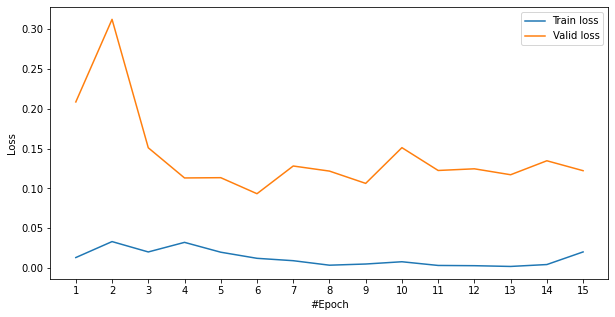

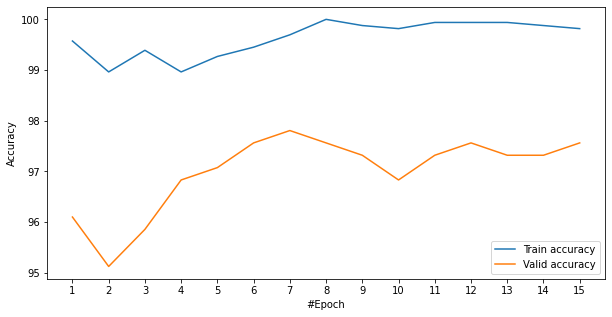

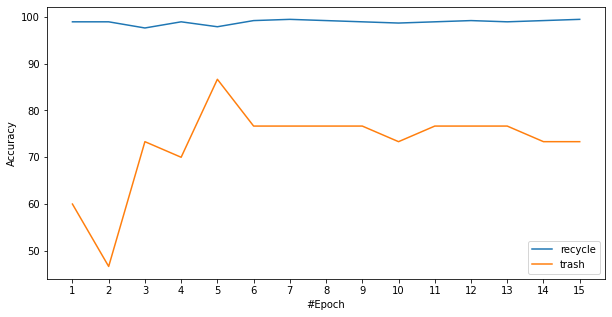

In [28]:
# 결과를 시각화 한다.
# 위에서부터 train, validation loss 그래프, train, validation accuracy 그래프, class별 validation accuracy 그래프를 의미한다.
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train loss')
plt.plot(epochs, valid_loss_hist, label='Valid loss')
plt.xlabel("#Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train accuracy')
plt.plot(epochs, valid_acc_hist, label='Valid accuracy')
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
for classname, accuracy in valid_class_acc_hist.items():
    plt.plot(epochs, accuracy, label='%s' % classname)
plt.xlabel("#Epoch")
plt.ylabel("Accuracy")
plt.xticks(epochs)
plt.legend()
plt.show()
